# 04_test_modflow_mf6
Authors : Valentin Dall'Alba & Alexis Neven

This notebook simulates groundwater flow in a karst aquifer using a binary karst network, stochastic conduit diameters, and MODFLOW 6. The workflow includes:
- Loading and visualizing a karst network and tunnel data
- Generating conduit diameters using a geostatistical random field
- Setting up boundary conditions and hydraulic properties
- Iteratively running MODFLOW 6, updating hydraulic conductivity based on flow regime (laminar/turbulent)
- Analyzing convergence, outflow, and hydraulic head results
- Visualizing the spatial distribution of hydraulic conductivity and heads

Dependencies: `pykasso`, `numpy`, `pandas`, `matplotlib`, `flopy`, and custom functions for model setup and analysis.

In [ ]:
import pykasso as pk
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import flopy as fp
from flopy.utils.gridintersect import GridIntersect

In [71]:
exec(open('generate_karst_functions/function_mf6_run.py').read())

### Load Karst network

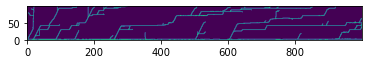

In [56]:
karst_binaire = np.loadtxt('pykasso_networks_simply_mf6/cas_test.txt')
plt.imshow(karst_binaire, origin='bot')

### Simulate Karst diameter

In [57]:
#Dimension karst and sgs grid
nx = karst_binaire.shape[1]
ny = karst_binaire.shape[0]
sx = 2
sy = 2

In [58]:
# Generation conduits
simu_grf = GRF_objt(typeModel='exponential')
simu_grf.set_dimension(dimension=[nx,ny],spacing=[sx,sy])
simu_grf.run_model_GRF(nb_real=1)
simu_grf.grf_to_cdf()
simu_grf.cdf_to_diameter()
karst_diameter = simu_grf.diameter[0]

In [59]:
karst_diameter.shape, karst_binaire.shape

((100, 1000), (100, 1000))

In [60]:
karst_diameter.max()

16.6894104643009

## Output tunnel location

In [61]:
tunnel_info = np.loadtxt('pykasso_networks_simply_mf6/tunel.txt')
tunnel_info

array([  92.,   13., 2724.])

### MF6 simulation

In [97]:
#grid
nx = karst_binaire.shape[1]
ny = karst_binaire.shape[0]
sx = 2
sy = 2
sz = 2

#boundary condition
position_out = [1,0]
cstIn  = [[(0,ny-1,i), 450] for i in range(nx)]  #Charge cst top
cstOut = [[(0,int(tunnel_info[1]),int(tunnel_info[0])), 0]]  #tunnel position
cst_bc = [cstIn, cstOut]

#conduit = 1 pour presence
conduit = np.zeros((ny,nx))
conduit[karst_binaire==1] = karst_diameter[karst_binaire==1]
#conduit[conduit!=0] = 0.1

#matrix first iteration
Km = 1e-7
kmatrix_homogene = np.ones((ny,nx))*Km
kmatrix = assign_k_laminar(kmatrix_homogene, karst_binaire, conduit/2, cell_size=sx, Km=Km)

#parameter nb run
diff_threshold   = 1e-3
nb_iteration_min = 5
nb_iteration_max = 15

#init variable
test    = False
outflow = 1
iteration = 0
diff_store    = []
km_store      = []
hd_store      = []
outflow_store = [outflow]

#run loop
while test is False or iteration<nb_iteration_min:
    #run Modflow
    run_all_mf6(kmatrix, nx, ny, sx, sy, sz, cst_bc, silent=True)
    
    #get outflow
    bdg         = fp.utils.Mf6ListBudget('file_modflow_6/model_mf6.lst')    
    outflow_new = bdg.get_budget()[0]['TOTAL_OUT'][0]
    diff_store.append(np.abs(outflow-outflow_new)/outflow)
    outflow_store.append(outflow_new)
    outflow     = outflow_new
    
    #get outputs
    cbc_flux = get_spdis('file_modflow_6/model_mf6.cbc')[0]
    velocity = get_velocity(cbc_flux, conduit/2, karst_binaire, sx, sy)
    hds      = get_hds('file_modflow_6/model_mf6.hds')
    grad_h   = get_gradient_y(hds, conduit, karst_binaire, sx=sx, sy=sy)
    hd_store.append(hds)
    
    #calculate Re
    rey_mat, rey_test = reynolds(velocity, conduit)
    
    #update k matrix    
    km_store.append(np.copy(kmatrix))
    k_t      = kturb(conduit/2, karst_binaire, cell_size=sx, Km=Km, gradh=grad_h)
    kmatrix  = update_km(kmatrix, k_t, karst_binaire, div=2)
    
    #test convergence
    if diff_store[iteration]<diff_threshold and iteration!=0:
        test = True
        
    iteration +=1 
    
    if iteration == nb_iteration_max:
        break
    print('Iteration number : {}'.format(iteration))

#print output information        
print('Number of iteration : {}'.format(iteration))
print('Final budget out : {}m3/s'.format((outflow)))
print('Final diff in out flow : {}m3/s'.format(diff_store[-1]))

Iteration number : 1
Iteration number : 2
Iteration number : 3
Iteration number : 4
Iteration number : 5
Iteration number : 6
Iteration number : 7
Iteration number : 8
Iteration number : 9
Iteration number : 10
Iteration number : 11
Iteration number : 12
Iteration number : 13
Iteration number : 14
Number of iteration : 15
Final budget out : 1247.9072265625m3/s
Final diff in out flow : 0.430434912443161m3/s


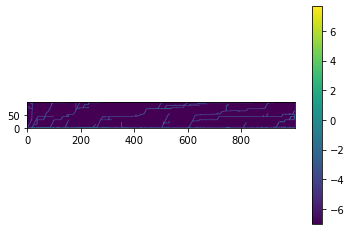

In [74]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

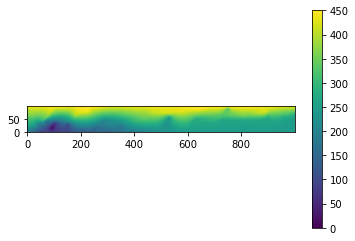

In [96]:
plt.imshow(hd_store[15][0],origin='bot')
plt.colorbar()

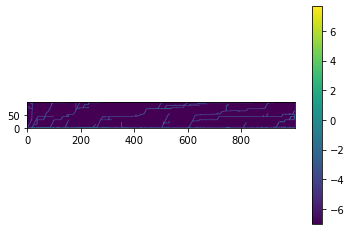

In [91]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

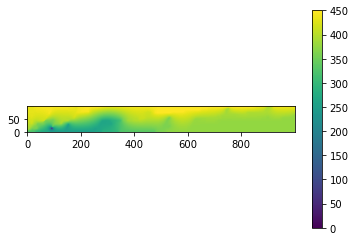

In [39]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()

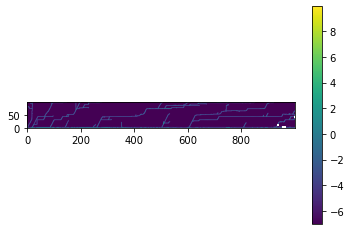

In [10]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

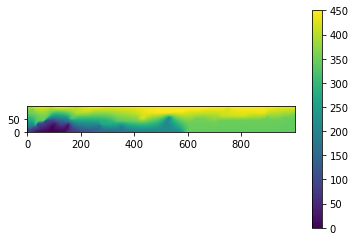

In [11]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()

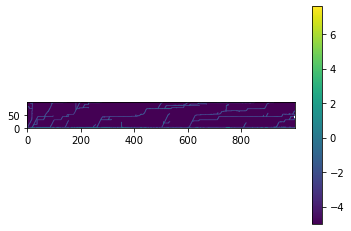

In [71]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

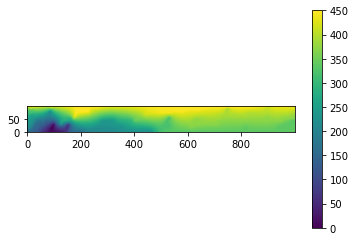

In [70]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()

2000x200 sx=2, sy=2, sz=2

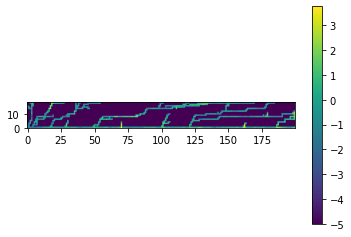

In [58]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

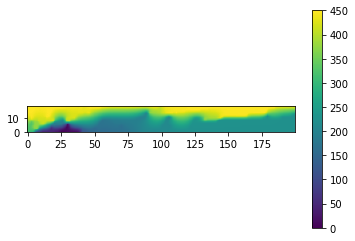

In [59]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()

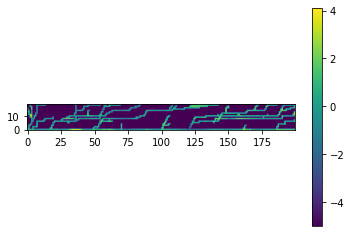

In [14]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

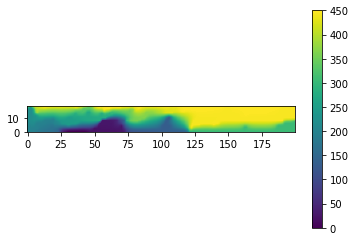

In [15]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()

1000x200

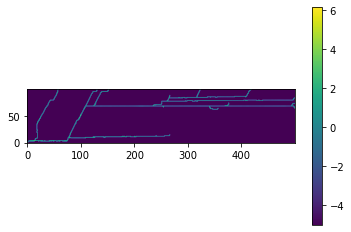

In [28]:
plt.imshow(np.log10(kmatrix),origin='bot')
plt.colorbar()

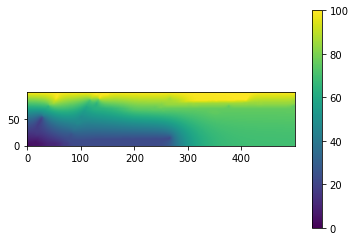

In [29]:
plt.imshow(hd_store[-1][0],origin='bot')
plt.colorbar()